# Разработка A/B-тестирования и анализ результатов

- Автор: Логинов Павел Александрович
- Дата: 19.04.2025

## Введение

### Описание данных

Таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

Начнём с загрузки библиотеки `pandas` (для работы со структурированными табличными данными), `matplotlib` (для визуализации данных), `NormalIndPower` (для вычисления статистической мощности z-теста для двух независимых выборок), `ceil` (для округления чисел до ближайшего целого значения в большую сторону), `ttest_ind` (для проведения статистического t-теста с двумя выборками), `proportions_ztest` (для проведения статистического Z-теста пропорций с двумя выборками) и датасета `sessions_project_history.csv`. Данные датасета сохраним в переменной `sessions_history`

In [1]:
# Импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные в переменную
try:
    sessions_history = pd.read_csv('C:/Users/Student/Desktop/sessions_project_history.csv')
except:
    sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

Познакомимся с данными датасета `sessions_project_history.csv` — выведем первые строки методом `head()`, а информацию о датафрейме методом `info()`:

In [3]:
# Выводим первые строки датафрейма на экран

sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим информацию о датафрейме

sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Датафрейм `sessions_history` содержит 10 столбцов и 435924 строки, в котором представлена информация о исторических данных по сессиям пользователей на период с *2025-08-15* по *2025-09-23*

После первичного анализа данных можно сделать следующие выводы:

- Названия столбцов приведены к единому виду
- Все представленные данные хранятся в типах данных `object` (строковые данные) или `int64` (целочисленные значения)
- **Строковые данные (object).** 7 столбцов имеют тип данных `object`:
    - `user_id` — идентификатор пользователя;
    - `session_id` — идентификатор сессии в приложении;
    - `session_date` — дата сессии;
    - `session_start_ts` — дата и время начала сессии;
    - `install_date` — дата установки приложения; 
    - `region` — регион пользователя;
    - `device` — тип устройства пользователя;
    
Стоит обратить внимание на тип данных столбцов `session_date`, `session_start_ts`, `install_date`, поскольку они содержат информацию о дате и времени того или иного события, но при этом обладают типом данных `object`. Поэтому приведём к более привычному виду (YYYY-MM-DD) столбцы с датами `session_date`, `session_start_ts` и `install_date`

In [5]:
# Изменяем тип данных столбцов с информацией о дате и времени с object на datetime64

sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'])
sessions_history['install_date'] = pd.to_datetime(sessions_history['install_date'])
sessions_history.head() 

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


Для остальных столбцов верно подобран строковый тип данных, поскольку отображается текстовая информация, которая не может быть представлена в числовом формате

- **Числовые значения с плавающей точкой (float64).** 3 столбца имеют тип данных `float64`:
    - `session_number` — порядковый номер сессии для конкретного пользователя;
    - `registration_flag` — является ли пользователь зарегистрированным;
    - `page_counter` — количество просмотренных страниц во время сессии;
    
Для данных столбцов верно подобран числовой тип данных с плавающей точкой, поскольку отображается информация о номере сессии, факте регистрации (0 - не зарегистрирован, 1 - зарегистрирован) и количестве просморенных страниц в числовом формате

- Столбцы датафрейма не содержат пропусков
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию

#### 1.2. Знакомство с данными

Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

In [6]:
# Определяем количество уникальных сессий для каждого пользователя

unique_session_id = sessions_history.groupby('user_id')['session_id'].nunique()
unique_session_id

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

Из предыдущей группировки уникальных сессий для каждого пользователя `unique_session_id` выделим пользователя с максимальным количеством уникальных сессий. Для этого отсортируем датафрейм `unique_session_id` по убыванию и оставим только первого пользователя

In [7]:
# Сортируем данные по убыванию

unique_session_id = unique_session_id.sort_values(ascending = False)
unique_session_id

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

Заметим, что максимальное количество уникальных сессий (10) наблюдается у двух пользователей. По условию задания необходимо изучить информацию о любом из пользователей с максимальным количеством уникальных сессий. Поэтому в качестве изучаемого пользователя возьмём данные о первом пользователе из датафрейма `unique_session_id`

In [8]:
# Выводим user_id пользователя с максимальным количеством уникальных сессий

unique_session_id.head(1)

user_id
10E0DEFC1ABDBBE0    10
Name: session_id, dtype: int64

Изучим таблицу c данными по сессиям этого пользователя, чтобы лучше понять логику формирования каждого столбца данных

In [9]:
# Делаем срез данных по одному из пользователей с максимальным количеством уникальных сессий

max_unique_session_id = sessions_history.loc[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']
max_unique_session_id

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


В датафрейме `sessions_history` фиксируется информация о том, сколько страниц (`page_counter`) пользователь (`user_id`) просмотрел в течение одной сессии (`session_id`). При этом для каждой сессии фиксируется номер сессии (`session_number`) дата начала сессии (`session_date`) и дата и время начала сессии (`session_start_ts`). Также можно увидеть информацию о дате установки приложения (`install_date`). Заметим, что во всех строках, принадлежащих сессиям одного пользователя, дата уставноки приложения - одна и та же. Помимо этого содержится информация о факте регистрации пользователя (`registration_flag`): 0 - не зарегистрирован, 1 - зарегистрирован. Также можно увидеть информацию о регионе пользователя (`region`) и типе устройства (`device`), с которых пользователь смотрит короткие видео

#### 1.3. Анализ числа регистраций

Расчитаем количество уникальных пользователей для каждого для наблюдения

In [10]:
# Рассчитываем количество уникальных пользователей для каждого дня наблюдения

count_day_unique_user_id = sessions_history.groupby('session_date')['user_id'].nunique()
count_day_unique_user_id

session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: user_id, dtype: int64

Затем рассчитаем количество зарегистрированных пользователей для каждого дня наблюдения

In [11]:
# Рассчитываем количество зарегистрированных пользователей для каждого дня наблюдения

count_reg_user_id = sessions_history[sessions_history['registration_flag'] == 1]
count_reg_user_id = count_reg_user_id.groupby('session_date')['user_id'].nunique()
count_reg_user_id

session_date
2025-08-11     169
2025-08-12     336
2025-08-13     464
2025-08-14     625
2025-08-15     840
2025-08-16     916
2025-08-17     833
2025-08-18     860
2025-08-19     831
2025-08-20    1008
2025-08-21    1063
2025-08-22    1251
2025-08-23    1253
2025-08-24    1181
2025-08-25    1060
2025-08-26    1050
2025-08-27    1076
2025-08-28    1175
2025-08-29    1174
2025-08-30    1165
2025-08-31    1105
2025-09-01    1028
2025-09-02    1039
2025-09-03    1035
2025-09-04    1007
2025-09-05    1030
2025-09-06    1023
2025-09-07    1069
2025-09-08    1009
2025-09-09     980
2025-09-10    1015
2025-09-11     824
2025-09-12     669
2025-09-13     537
2025-09-14     440
2025-09-15     383
2025-09-16     286
2025-09-17     272
2025-09-18     201
2025-09-19     132
2025-09-20     107
2025-09-21      87
2025-09-22      68
2025-09-23      32
Name: user_id, dtype: int64

Для визуализации расчёта уникальных пользователей и числа зарегистрированных пользователей для каждого дня наблюдения построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням, отобразив их на одном графике

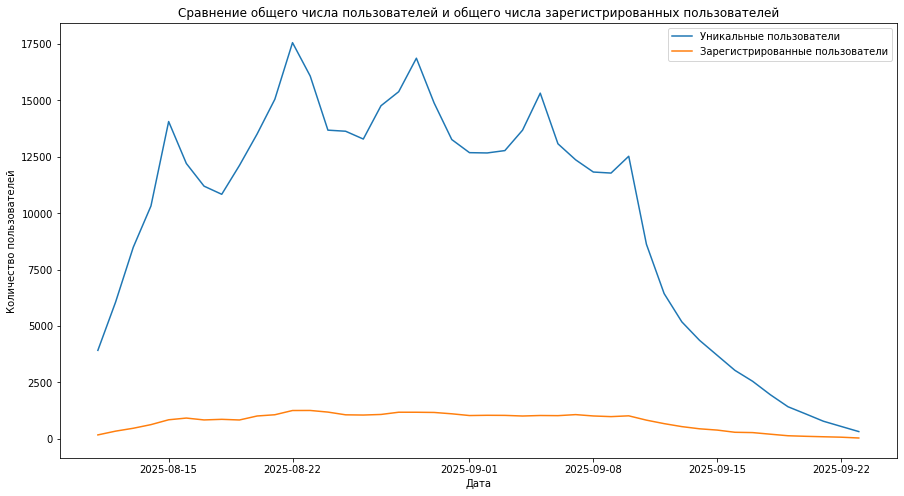

,unique_users,registered_users
session_date,,
2025-08-11,3919,169
2025-08-12,6056,336
2025-08-13,8489,464
2025-08-14,10321,625
2025-08-15,14065,840
2025-08-16,12205,916
2025-08-17,11200,833
2025-08-18,10839,860
2025-08-19,12118,831


In [12]:
# Построим график линейной диаграммы

x = count_day_unique_user_id.index
y_a = count_day_unique_user_id.values
y_b = count_reg_user_id.values

plt.figure(figsize=(15, 8))
plt.plot(x, y_a, label ='Уникальные пользователи')
plt.plot(x, y_b,label ='Зарегистрированные пользователи')

plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.legend()
plt.title('Сравнение общего числа пользователей и общего числа зарегистрированных пользователей')
plt.show()

general_table = pd.concat([count_day_unique_user_id.rename('unique_users'), count_reg_user_id.rename('registered_users')], axis=1)
general_table

Исходя из построенных графиков и табличного представления построенных графиков, мы можем увидеть, что рост числа уникальных и зарегистрированных пользователей наблюдается с 11 по 15 августа. Затем с 16 августа по 9 сентября число уникальных пользователей находится на уровне 10-17 тысяч пользователей, число зарегистрированных пользователей находится на уровне 1000-1300 пользователей. С 10 по 23 сентября наблюдается снижение числа уникальных и зарегистрированных пользователей 

Рассчитаем долю зарегистрированных пользователей от всех пользователей по дням в %

In [13]:
# Рассчитываем долю зарегистрированных пользователей от всех пользователей по дням в %

prop_count_reg_user_id = (count_reg_user_id/sessions_history['user_id'].nunique())*100
prop_count_reg_user_id

session_date
2025-08-11    0.126083
2025-08-12    0.250673
2025-08-13    0.346168
2025-08-14    0.466282
2025-08-15    0.626683
2025-08-16    0.683383
2025-08-17    0.621461
2025-08-18    0.641604
2025-08-19    0.619969
2025-08-20    0.752020
2025-08-21    0.793053
2025-08-22    0.933310
2025-08-23    0.934803
2025-08-24    0.881087
2025-08-25    0.790815
2025-08-26    0.783354
2025-08-27    0.802751
2025-08-28    0.876611
2025-08-29    0.875864
2025-08-30    0.869150
2025-08-31    0.824387
2025-09-01    0.766941
2025-09-02    0.775148
2025-09-03    0.772163
2025-09-04    0.751274
2025-09-05    0.768433
2025-09-06    0.763211
2025-09-07    0.797529
2025-09-08    0.752766
2025-09-09    0.731130
2025-09-10    0.757242
2025-09-11    0.614746
2025-09-12    0.499108
2025-09-13    0.400630
2025-09-14    0.328263
2025-09-15    0.285738
2025-09-16    0.213371
2025-09-17    0.202926
2025-09-18    0.149956
2025-09-19    0.098479
2025-09-20    0.079828
2025-09-21    0.064906
2025-09-22    0.05073

Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням

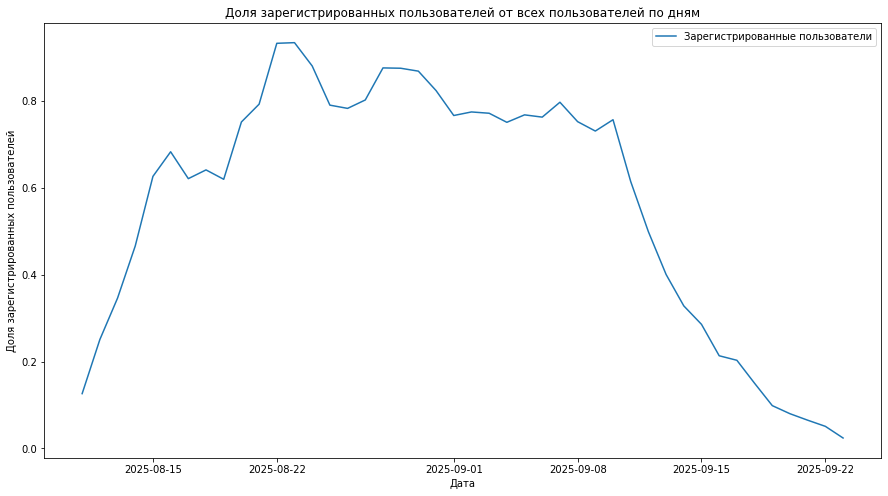

In [14]:
# Построим график линейной диаграммы

plt.figure(figsize=(15, 8))
plt.plot(prop_count_reg_user_id.index, prop_count_reg_user_id.values, label ='Зарегистрированные пользователи')

plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных пользователей")
plt.legend()
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.show()

Исходя из построенного графика, мы можем увидеть, что доля зарегистрированных пользователей от всех пользователей по дням ни в один из дней не превышает 1% пользователей

#### 1.4. Анализ числа просмотренных страниц

Найдём количество сессий для каждого значения количества просмотренных страниц

In [15]:
# Находим количество сессий для каждого значения количества просмотренных страниц

value_counts_page_counter = sessions_history.groupby('page_counter')['session_id'].count()
value_counts_page_counter

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий

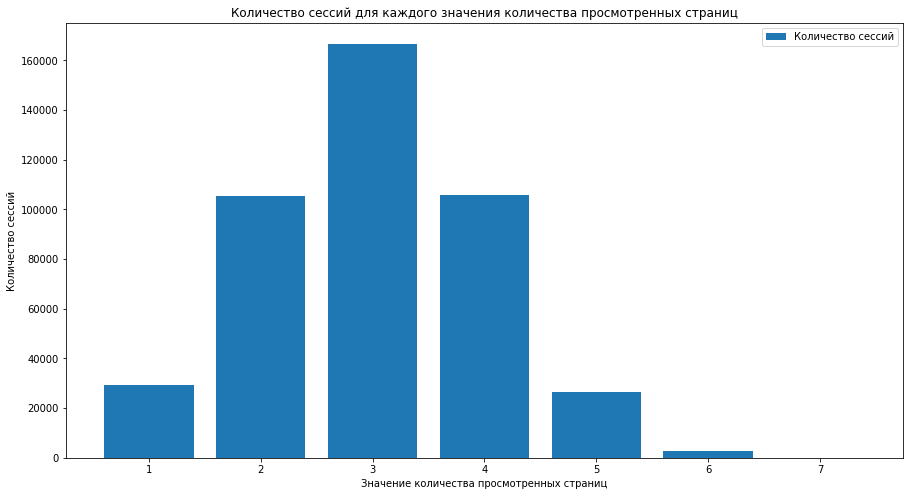

In [16]:
# Построим график столбчатой диаграммы

plt.figure(figsize=(15, 8))
plt.bar(value_counts_page_counter.index, value_counts_page_counter.values, label ='Количество сессий')

plt.xlabel("Значение количества просмотренных страниц")
plt.ylabel("Количество сессий")
plt.legend()
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.show()

Исходя из построенного графика, мы можем заметить, что наименьшее количество сессий характерно для 7 просмотренных страниц, а наибольшее количество сессий характерно для 3 просмотренных страниц

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

В датафрейм `sessions_history` добавим столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше.

In [17]:
# Создаём дополнительный столбец good_session, исходя из заданных условий

def good_session_0_1(value):
    if value < 4:
        return 0
    else:
        return 1

sessions_history['good_session'] = sessions_history['page_counter'].apply(good_session_0_1)
sessions_history

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0
...,...,...,...,...,...,...,...,...,...,...,...
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC,0
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone,1
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android,1
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC,1


Рассчитаем количество успешных сессий по дням за весь период наблюдения

In [18]:
# Рассчитываем количество успешных сессий по дням

good_session_1 = sessions_history.groupby('session_date')['good_session'].sum()
good_session_1

session_date
2025-08-11    1226
2025-08-12    1829
2025-08-13    2604
2025-08-14    3262
2025-08-15    4289
2025-08-16    3737
2025-08-17    3557
2025-08-18    3366
2025-08-19    3791
2025-08-20    4148
2025-08-21    4563
2025-08-22    5500
2025-08-23    4858
2025-08-24    4239
2025-08-25    4165
2025-08-26    4132
2025-08-27    4594
2025-08-28    4779
2025-08-29    5283
2025-08-30    4673
2025-08-31    4013
2025-09-01    3964
2025-09-02    3998
2025-09-03    3886
2025-09-04    4317
2025-09-05    4656
2025-09-06    3983
2025-09-07    3860
2025-09-08    3652
2025-09-09    3599
2025-09-10    3822
2025-09-11    2627
2025-09-12    1941
2025-09-13    1550
2025-09-14    1343
2025-09-15    1131
2025-09-16     946
2025-09-17     816
2025-09-18     571
2025-09-19     451
2025-09-20     332
2025-09-21     224
2025-09-22     169
2025-09-23      92
Name: good_session, dtype: int64

Рассчитаем количество всех сессий по дням за весь период наблюдения

In [19]:
# Рассчитываем количество всех сессий по дням

all_session = sessions_history.groupby('session_date')['session_id'].count()
all_session

session_date
2025-08-11     3919
2025-08-12     6056
2025-08-13     8489
2025-08-14    10321
2025-08-15    14065
2025-08-16    12205
2025-08-17    11200
2025-08-18    10839
2025-08-19    12118
2025-08-20    13514
2025-08-21    15051
2025-08-22    17563
2025-08-23    16082
2025-08-24    13683
2025-08-25    13635
2025-08-26    13289
2025-08-27    14766
2025-08-28    15388
2025-08-29    16873
2025-08-30    14891
2025-08-31    13266
2025-09-01    12685
2025-09-02    12672
2025-09-03    12777
2025-09-04    13683
2025-09-05    15324
2025-09-06    13078
2025-09-07    12367
2025-09-08    11826
2025-09-09    11780
2025-09-10    12526
2025-09-11     8623
2025-09-12     6436
2025-09-13     5183
2025-09-14     4364
2025-09-15     3698
2025-09-16     3032
2025-09-17     2548
2025-09-18     1952
2025-09-19     1418
2025-09-20     1100
2025-09-21      776
2025-09-22      546
2025-09-23      317
Name: session_id, dtype: int64

Рассчитаем среднее значение доли успешных сессий ко всем сессиям по дням за весь период наблюдения в %

In [20]:
# Рассчитаем среднее значением доли успешных сессий по дням

prop_good_session_1 = (good_session_1/all_session)*100
prop_good_session_1

session_date
2025-08-11    31.283491
2025-08-12    30.201453
2025-08-13    30.674991
2025-08-14    31.605465
2025-08-15    30.494134
2025-08-16    30.618599
2025-08-17    31.758929
2025-08-18    31.054525
2025-08-19    31.284040
2025-08-20    30.694095
2025-08-21    30.316922
2025-08-22    31.315834
2025-08-23    30.207686
2025-08-24    30.980048
2025-08-25    30.546388
2025-08-26    31.093386
2025-08-27    31.112014
2025-08-28    31.056668
2025-08-29    31.310378
2025-08-30    31.381371
2025-08-31    30.250264
2025-09-01    31.249507
2025-09-02    31.549874
2025-09-03    30.414025
2025-09-04    31.550099
2025-09-05    30.383712
2025-09-06    30.455727
2025-09-07    31.212097
2025-09-08    30.881109
2025-09-09    30.551783
2025-09-10    30.512534
2025-09-11    30.465035
2025-09-12    30.158484
2025-09-13    29.905460
2025-09-14    30.774519
2025-09-15    30.584100
2025-09-16    31.200528
2025-09-17    32.025118
2025-09-18    29.252049
2025-09-19    31.805360
2025-09-20    30.181818
202

Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения в %

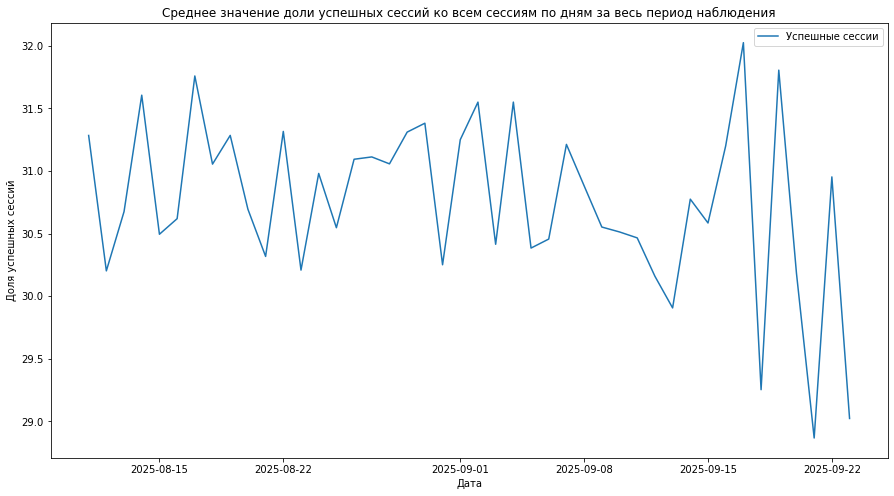

,all_session,good_session_1,prop_good_session_1
session_date,,,
2025-08-11,3919,1226,31.283491
2025-08-12,6056,1829,30.201453
2025-08-13,8489,2604,30.674991
2025-08-14,10321,3262,31.605465
2025-08-15,14065,4289,30.494134
2025-08-16,12205,3737,30.618599
2025-08-17,11200,3557,31.758929
2025-08-18,10839,3366,31.054525
2025-08-19,12118,3791,31.284040


In [21]:
# Построим график линейной диаграммы

plt.figure(figsize=(15, 8))
plt.plot(prop_good_session_1.index, prop_good_session_1.values, label ='Успешные сессии')

plt.xlabel("Дата")
plt.ylabel("Доля успешных сессий")
plt.legend()
plt.title('Среднее значение доли успешных сессий ко всем сессиям по дням за весь период наблюдения')
plt.show()

general_table_1 = pd.concat([all_session.rename('all_session'), good_session_1.rename('good_session_1'), prop_good_session_1.rename('prop_good_session_1')], axis=1)
general_table_1

Исходя из построенного графика и табличного представления построенного графика, мы можем увидить, что в среднем значение доли успешных сессий по дням составлят от 28% до 32%

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки

Рассчитаем необходимое для дизайна эксперимента количество пользователей при заданных параметрах:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста.
- Минимальный детектируемый эффект, или MDE, — 3%.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [22]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


Исходя из полученных вычислений, мы можем увидеть, что необходимое для дизайна эксперимента количество пользователей при заданных параметрах составляет 17441 пользователь для каждой группы

#### 2.1. Расчёт длительности A/B-теста

Рассчитаем среднее количество уникальных пользователей приложения в день и определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону

In [23]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size*2)/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


Исходя из полученных вычислений, мы можем увидеть, что рассчитанная длительность A/B теста при текущем трафике в 9907 пользователей составит 4 дня

Исходя из полученных вычислений, мы можем увидеть, что среднее количество уникальных пользователей в день составляет 9907 пользователей, а рассчитанная длительность A/B теста составит 4 дня

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

Сохраним в датафрейм `sessions_test_part` CSV-файл `sessions_project_test_part.csv` с данными за первый день проведения A/B-теста, то есть за 2025-10-14 

In [24]:
# Выгружаем данные в переменную
try:
    sessions_test_part = pd.read_csv('C:/Users/Student/Desktop/sessions_project_test_part.csv')
except:
    sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения

In [25]:
# Рассчитываем количество уникальных пользователей для одного дня наблюдения

count_test_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
count_test_group

test_group
A    1477
B    1466
Name: user_id, dtype: int64

Исходя из вычислений, можем увидеть, что в контрольной группе (А) содержится 1477 уникальных пользователей, а в тестовой группе (B) содержится 1466 уникальных пользователей

Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [26]:
# Рассчитываем процентную разницу в количестве пользователей в группах A и B

A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

difference_a_b = 100 * (abs(A-B)/A)
difference_a_b

0.7447528774542992

Построим визуализацию, на которой можно было бы увидеть возможное различие двух групп.

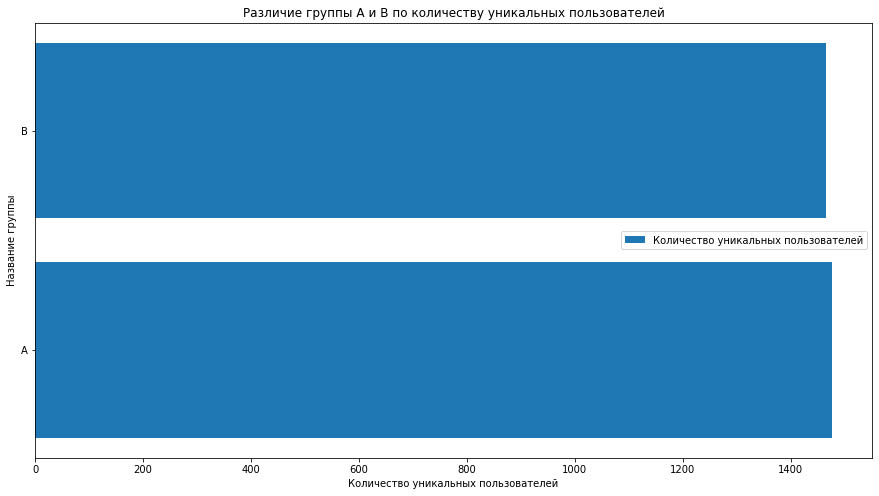

In [27]:
# Построим график линейчатой диаграммы

plt.figure(figsize=(15, 8))
plt.barh(count_test_group.index, count_test_group.values, label ='Количество уникальных пользователей')

plt.xlabel("Количество уникальных пользователей")
plt.ylabel("Название группы")
plt.legend()
plt.title('Различие группы A и B по количеству уникальных пользователей')
plt.show()

Исходя из вычислений и построенного графика, мы можем увидеть, что между группами не наблюдается ощутимая разница (меньше 1%). Поэтому расхождением в 11 пользователей можно пренебречь

#### 3.2. Проверка пересечений пользователей

Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, чтобы убедиться в том, что никто из пользователей случайно не попал в обе группы одновременно

In [28]:
a1 = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
b1 = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(a1) & set(b1))
print(intersection)

[]


После выполнения данного кода мы видим, что пользователей, которые встречаются одновременного в группах A и B - нет

#### 3.3. Равномерность разделения пользователей по устройствам

Cоздадим два среза данных: пользователи, которые входят в группу A, пользователи, которые входят в группу B

In [29]:
# Создаём срезы данных

group_a = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b = sessions_test_part[sessions_test_part['test_group'] == 'B']

Рассчитаем доли каждого типа устройства для пользователей из группы A

In [30]:
# Рассчитываем долю каждого типа устройства для пользователей из группы A

device_group_a = (group_a.groupby('device')['user_id'].nunique()/group_a['user_id'].nunique())*100
device_group_a = device_group_a.sort_values(ascending = False)
device_group_a

device
Android    44.414353
PC         24.983074
iPhone     20.040623
Mac        10.561950
Name: user_id, dtype: float64

Построим диаграмму для визуализации доли каждого типа устройства для пользователей из группы A

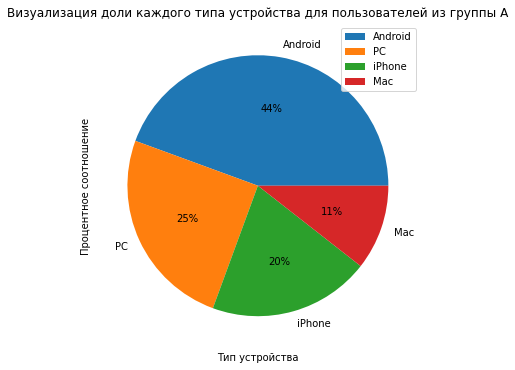

In [31]:
# Строим круговую диаграмму

plt.figure(figsize=(8, 6))

device_group_a.plot(
               kind='pie',
               autopct = '%1.0f%%',
               legend=True,
               title=f'Визуализация доли каждого типа устройства для пользователей из группы A'
)

plt.xlabel('Тип устройства')
plt.ylabel('Процентное соотношение')
plt.grid()

plt.show()

Рассчитаем доли каждого типа устройства для пользователей из группы B

In [32]:
# Рассчитываем долю каждого типа устройства для пользователей из группы B

device_group_b = (group_b.groupby('device')['user_id'].nunique()/group_b['user_id'].nunique())*100
device_group_b = device_group_b.sort_values(ascending = False)
device_group_b

device
Android    45.566166
PC         25.989086
iPhone     18.349250
Mac        10.095498
Name: user_id, dtype: float64

Построим диаграмму для визуализации доли каждого типа устройства для пользователей из группы B

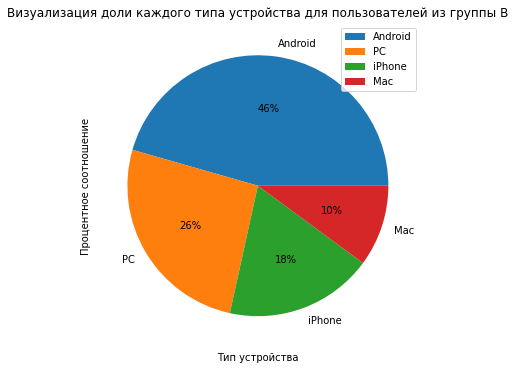

In [33]:
# Строим круговую диаграмму

plt.figure(figsize=(8, 6))

device_group_b.plot(
               kind='pie',
               autopct = '%1.0f%%',
               legend=True,
               title=f'Визуализация доли каждого типа устройства для пользователей из группы B'
)

plt.xlabel('Тип устройства')
plt.ylabel('Процентное соотношение')
plt.grid()

plt.show()

Объединим данные о долях каждого типа устройства для пользователей из групп A и B

In [34]:
# Объединяем данные о долях каждого типа устройства для пользователей из групп A и B

general_table_2 = pd.concat([device_group_a.rename('device_a'), device_group_b.rename('device_b')], axis=1)
general_table_2

,device_a,device_b
device,,
Android,44.414353,45.566166
PC,24.983074,25.989086
iPhone,20.040623,18.349250
Mac,10.561950,10.095498


Построим диаграмму для визуализации доли каждого типа устройства для пользователей из группы A и из группы B

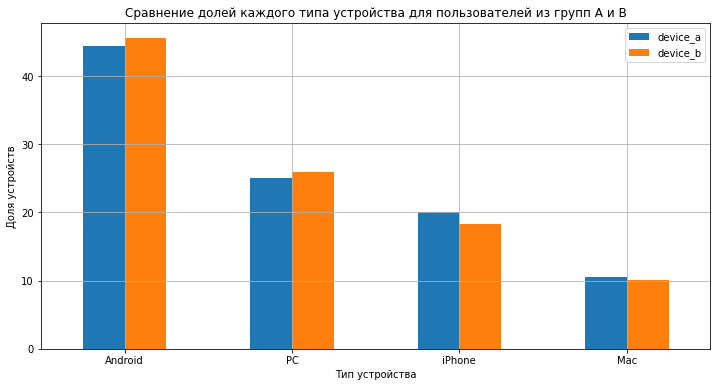

In [35]:
# Построим график столбчатой диаграммы

general_table_2.plot(kind='bar',
               title=f'Сравнение долей каждого типа устройства для пользователей из групп A и B',
               legend=True,
               ylabel='Доля устройств',
               xlabel='Тип устройства',
               rot=0,
               figsize=(12, 6))
plt.grid()

plt.show()

Исходя из построенных графиков, мы можем увидеть, что распределение устройств в группах A и B - практически идентично:

- `Android`: группа A - 44.4%, группа B - 45.5%
- `PC`: группа A - 24.9%, группа B - 25.9%
- `iPhone`: группа A - 20%, группа B - 18.3%
- `Mac`: группа A - 10.5%, группа B - 10%

Следовательно, мы можем сделать вывод о том, что распределение устройств в группах A и B - совпадает

#### 3.4. Равномерность распределения пользователей по регионам

Рассчитаем доли каждого региона для пользователей из группы A

In [36]:
# Рассчитываем долю каждого региона для пользователей из группы A

region_group_a = (group_a.groupby('region')['user_id'].nunique()/group_a['user_id'].nunique())*100
region_group_a = region_group_a.sort_values(ascending = False)
region_group_a

region
CIS     43.601896
MENA    41.232227
EU      15.165877
Name: user_id, dtype: float64

Построим диаграмму для визуализации доли каждого региона для пользователей из группы A

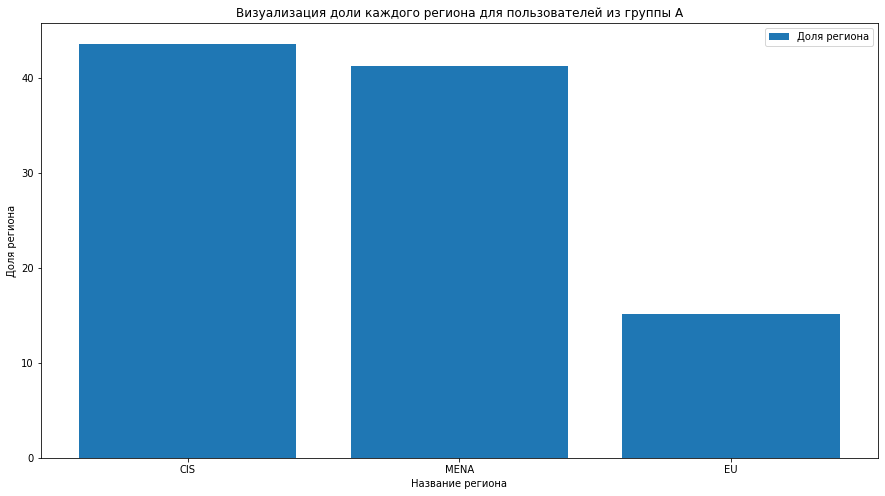

In [37]:
# Построим график столбчатой диаграммы

plt.figure(figsize=(15, 8))
plt.bar(region_group_a.index, region_group_a.values, label ='Доля региона')

plt.xlabel("Название региона")
plt.ylabel("Доля региона")
plt.legend()
plt.title('Визуализация доли каждого региона для пользователей из группы A')
plt.show()

Рассчитаем доли каждого региона для пользователей из группы B

In [38]:
# Рассчитываем долю каждого региона для пользователей из группы B

region_group_b = (group_b.groupby('region')['user_id'].nunique()/group_b['user_id'].nunique())*100
region_group_b = region_group_b.sort_values(ascending = False)
region_group_b

region
CIS     43.997271
MENA    41.200546
EU      14.802183
Name: user_id, dtype: float64

Построим диаграмму для визуализации доли каждого региона для пользователей из группы B

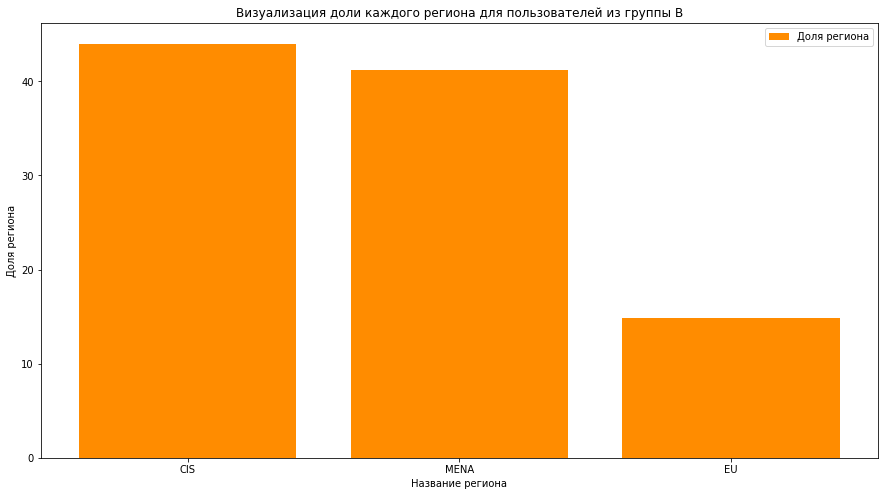

In [39]:
# Построим график столбчатой диаграммы

plt.figure(figsize=(15, 8))
plt.bar(region_group_b.index, region_group_b.values, label ='Доля региона', color = 'darkorange')

plt.xlabel("Название региона")
plt.ylabel("Доля региона")
plt.legend()
plt.title('Визуализация доли каждого региона для пользователей из группы B')
plt.show()

Объединим данные о долях каждого региона для пользователей из группы A и из группы B

In [40]:
# Объединяем данные о долях каждого региона для пользователей из групп A и B

general_table_3 = pd.concat([region_group_a.rename('region_a'), region_group_b.rename('region_b')], axis=1)
general_table_3

,region_a,region_b
region,,
CIS,43.601896,43.997271
MENA,41.232227,41.200546
EU,15.165877,14.802183


Построим диаграмму для визуализации доли каждого региона для пользователей из группы A и из группы B

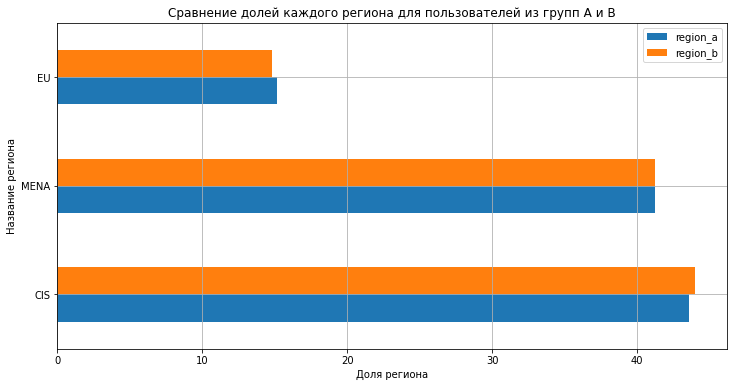

In [41]:
# Построим график столбчатой диаграммы

general_table_3.plot(kind='barh',
               title=f'Сравнение долей каждого региона для пользователей из групп A и B',
               legend=True,
               rot=0,
               figsize=(12, 6))

plt.xlabel("Доля региона")
plt.ylabel("Название региона")
plt.grid()

plt.show()

Исходя из построенных графиков, мы можем увидеть, что распределение регионов в группах A и B - практически идентично:

- `CIS`: группа A - 43.6%, группа B - 43.9%
- `MENA`: группа A - 41.23%, группа B - 41.2%
- `EU`: группа A - 15.1%, группа B - 14.8%

Следовательно, мы можем сделать вывод о том, что распределение регионов в группах A и B - совпадает

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B теста можно сделать следующие выводы:

- Различие в количестве пользователей в двух группах составило 11 пользователей (менее 1%), что не влияет на корректность проведения A/B теста
- Выборки являются независимыми, поскольку пересечение пользователей из тестовой и контрольной групп - не обнаружено
- Между тестовой и контрольной группами по категориальным переменным (устройствам и регионам) сохраняется равномерное распределение пользователей (максимальная разница в устройствах - менее 2%, максимальная разница в регионах - менее 1%)

Таким образом, мы можем сделать заключение о том, что A/B проходит корректно и никаких нарушений - не наблюдается

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

Сохраним в датафрейм `sessions_test` CSV-файл `sessions_project_test.csv` с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02

In [42]:
# Выгружаем данные в переменную
try:
    sessions_test = pd.read_csv('C:/Users/Student/Desktop/sessions_project_test.csv')
except:
    sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

В датафрейм `sessions_test` добавим столбец `good_session`. В него войдёт значение 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0, если было просмотрено меньше.

In [43]:
# Создаём дополнительный столбец good_session, исходя из заданных условий

sessions_test['good_session'] = sessions_test['page_counter'].apply(good_session_0_1)
sessions_test

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


Таким образом, мы получили новый датафрейм `sessions_test`, основанный на данных за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02, а также добавили в него столбец `good_session`, который содержит в себе информацию об успешных сессиях (значение 0 - если за одну сессию было просмотрено меньше 4 страниц, 1 - если за одну сессию было просмотрено 4 и более страниц)

#### 4.2. Проверка корректности результатов теста

Cоздадим два среза данных: пользователи, которые входят в группу A, пользователи, которые входят в группу B

In [44]:
# Создаём срезы данных

group_a1 = sessions_test[sessions_test['test_group'] == 'A']
group_b1 = sessions_test[sessions_test['test_group'] == 'B']

Рассчитаем количество уникальных сессий для каждого дня в контрольной группе

In [45]:
# Рассчитываем количество уникальных сессий для каждого дня в контрольной группе

unique_session_a = group_a1.groupby('session_date')['session_id'].nunique()
unique_session_a

session_date
2025-10-14    1502
2025-10-15    2235
2025-10-16    3280
2025-10-17    4089
2025-10-18    5013
2025-10-19    6535
2025-10-20    5837
2025-10-21    3927
2025-10-22    3083
2025-10-23    2470
2025-10-24    2090
2025-10-25    1897
2025-10-26    1669
2025-10-27    1454
2025-10-28    1279
2025-10-29    1068
2025-10-30     887
2025-10-31     644
2025-11-01     434
2025-11-02     158
Name: session_id, dtype: int64

Рассчитаем количество уникальных сессий для каждого дня в тестовой группе

In [46]:
# Рассчитываем количество уникальных сессий для каждого дня в тестовой группе

unique_session_b = group_b1.groupby('session_date')['session_id'].nunique()
unique_session_b

session_date
2025-10-14    1628
2025-10-15    2283
2025-10-16    3241
2025-10-17    4054
2025-10-18    5059
2025-10-19    6779
2025-10-20    6089
2025-10-21    3981
2025-10-22    3111
2025-10-23    2548
2025-10-24    2068
2025-10-25    1814
2025-10-26    1692
2025-10-27    1517
2025-10-28    1289
2025-10-29    1131
2025-10-30     876
2025-10-31     669
2025-11-01     465
2025-11-02     160
Name: session_id, dtype: int64

Объединим данные о количестве уникальных сессий для пользователей из группы A и из группы B

In [47]:
# Объединяем данные о долях каждого региона для пользователей из групп A и B

general_table_4 = pd.concat([unique_session_a.rename('session_a'), unique_session_b.rename('session_b')], axis=1)
general_table_4

,session_a,session_b
session_date,,
2025-10-14,1502,1628
2025-10-15,2235,2283
2025-10-16,3280,3241
2025-10-17,4089,4054
2025-10-18,5013,5059
2025-10-19,6535,6779
2025-10-20,5837,6089
2025-10-21,3927,3981
2025-10-22,3083,3111


Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используем статистический тест Стьюдента, который позволит сделать вывод о равенстве средних двух выборок.

In [48]:
# Выборка средних сессий для группы А
sample_a = general_table_4['session_a']
# Выборка средних сессий для группы B
sample_b = general_table_4['session_b']

test_result = ttest_ind(
    sample_a,
    sample_b,
    alternative='two-sided' # HO: mu_a = mu_b, H1: mu_a ≠ mu_b
)

# Фиксируем уровень значимости
alpha = 0.05

if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу')

pvalue=0.938219304859116 > 0.05
Не получилось отвергнуть нулевую гипотезу


Так как pvalue = 0.938219304859116 > 0.05, мы можем сделать вывод о том, что нулевую гипотезу отвергнуть не получилось. Это значит, что статистически значимых различий среднего количества уникальных сессий двух выборок при уровне значимости alpha = 0.05 - не наблюдается

#### 4.3. Сравнение доли успешных сессий

Рассчитаем долю успешных сессий для выборки A

In [49]:
# Рассчитываем долю успешных сессий для выборки A

prop_good_session_a = (group_a1['good_session'].sum()/group_a1['session_id'].nunique())
prop_good_session_a

0.3077233557344958

Рассчитаем долю успешных сессий для выборки B

In [50]:
# Рассчитываем долю успешных сессий для выборки A

prop_good_session_b = (group_b1['good_session'].sum()/group_b1['session_id'].nunique())
prop_good_session_b

0.31828992745867524

Рассчитаем разницу между долей успешных сессий для выборки A и долей успешных сессий для выборки B

In [51]:
# Рассчитываем разницу между долей успешных сессий для выборки A и долей успешных сессий для выборки B

prog_good_session_a_b = prop_good_session_a - prop_good_session_b
prog_good_session_a_b

-0.010566571724179463

Исходя из вычисленных, можно сделать вывод о том, что доля успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной выборке

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым. Для этого используем статистический Z-тест пропорций, поскольку диапазон значений нашей метрики колеблется от 0 до 1

In [52]:
n_a = group_a1.shape[0] # размер группы A

n_b = group_b1.shape[0] # размер группы B

m_a = group_a1['good_session'].sum() # количество успешных сессий в группе A

m_b = group_b1['good_session'].sum() # количество успешных сессий в группе B

p_a, p_b = m_a/n_a, m_b/n_b # доли успешных сессий для каждой группы: A и B

if (p_a*n_a>10)and((1-p_a)*n_a>10)and(p_b*n_b>10)and((1-p_b)*n_b>10): # проверяем предпосылку о достаточном количестве данных
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных не выполняется!')

alpha = 0.05 ## установите уровень значимости


stat_ztest, p_value_ztest = proportions_ztest(
  [m_a, m_b],
  [n_a, n_b],
  alternative='smaller' # проводим Z-тест пропорций, H0: p_a = p_b, H1: p_a < p_b, так как мы проверяем: значимо ли статистически увеличение доли успешных сессий в группе B по сравнению с группой A
) 

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
    print('Статистически значимое увеличение доли успешных сессий в группе B по сравнению с группой A - не наблюдается')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Отвергаем нулевую гипотезу')
    print('Наблюдается статистически значимое изменение доли успешных сессий в группе B по сравнению с группой A')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0001574739988036123 < 0.05
Отвергаем нулевую гипотезу
Наблюдается статистически значимое изменение доли успешных сессий в группе B по сравнению с группой A


Так как pvalue = 0.0001574739988036123 < 0.05, мы можем сделать вывод о том, что мы отвергаем нулевую гипотезу. Это значит, что наблюдается статичестически значимое увеличение доли успешных сессий в группе B по сравнению с группой A при уровне значимости alpha = 0.05

#### 4.5. Вывод по результатам A/B-эксперимента

Характеристики проведённого эксперимента:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста - 0.8.
- Минимальный детектируемый эффект, или MDE, — 3%.
- Необходимый размер выборки для каждой группы: 17441 пользователь
- Рассчитанная длительность A/B теста составила 4 дня

На основе проведённого анализа результатов теста по вышезаданным параметрам мы можем сделать следующие выводы:

- Внедрение нового алгоритма рекомендаций увеличило ключевую метрику на 1.1%. То есть, произошло увеличение доли успешных сессий на 1.1%
- 0.0001574739988036123 - значение p-value, которое использовалось для оценки статистической значимости выявленного эффекта
- Данное нововведение стоит внедрять в приложение, поскольку проведённый Z-тест пропорций показал, что существует статистически значимое различие доли успешных сессий в группе B по сравнению с группой A. Если быть точнее, то в тестовой группе B наблюдается статически значимое увеличение доли успешных сессий по сравнению с контрольной группой A на 1.1%